## 读取并选择数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
accepts = pd.read_csv('accepts.csv')
rejects = pd.read_csv('rejects.csv')

accepts_x = accepts[["tot_derog","age_oldest_tr","rev_util","fico_score","ltv"]]
accepts_y = accepts['bad_ind']
rejects_x = rejects[["tot_derog","age_oldest_tr","rev_util","fico_score","ltv"]]

### 查看数据集信息

In [2]:
rejects_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4233 entries, 0 to 4232
Data columns (total 5 columns):
tot_derog        4100 non-null float64
age_oldest_tr    4099 non-null float64
rev_util         4233 non-null int64
fico_score       4051 non-null float64
ltv              4233 non-null int64
dtypes: float64(3), int64(2)
memory usage: 165.5 KB


### 定义缺失值替换函数

In [3]:
def Myfillna_median(df):
    for i in df.columns:
        median = df[i].median()
        df[i].fillna(value=median, inplace=True)
    return df

### 缺失值填补

In [4]:
accepts_x_filled=Myfillna_median(df=accepts_x)

rejects_x_filled=Myfillna_median(df=rejects_x)

D:\Anaconda\anaconda\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


### 标准化数据

In [5]:
from sklearn.preprocessing import Normalizer
accepts_x_norm = pd.DataFrame(Normalizer().fit_transform(accepts_x_filled))
accepts_x_norm.columns = accepts_x_filled.columns

rejects_x_norm = pd.DataFrame(Normalizer().fit_transform(rejects_x_filled))
rejects_x_norm.columns = rejects_x_filled.columns


### 利用knn模型进行预测，做拒绝推断

In [25]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5, weights='distance')
neigh.fit(accepts_x_norm, accepts_y)
# rejects['bad_ind'] = neigh.predict(rejects_x_norm)
print(neigh)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')


### 将审核通过的申请者和未通过的申请者进行合并

In [9]:
rejects_res = rejects[rejects['bad_ind'] == 0].sample(1340)
rejects_res = pd.concat([rejects_res, rejects[rejects['bad_ind'] == 1]], axis = 0)
data = pd.concat([accepts.iloc[:, 2:-1], rejects_res.iloc[:,1:]], axis = 0)

D:\Anaconda\anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


### 分类变量转换

In [10]:
bankruptcy_dict = {'N':0, 'Y':1}
data.bankruptcy_ind = data.bankruptcy_ind.map(bankruptcy_dict)

### 处理异常值

In [11]:
year_min = data.vehicle_year.quantile(0.1)
year_max = data.vehicle_year.quantile(0.99)
data.vehicle_year = data.vehicle_year.map(lambda x: year_min if x <= year_min else x)
data.vehicle_year = data.vehicle_year.map(lambda x: year_max if x >= year_max else x)
data.vehicle_year = data.vehicle_year.map(lambda x: 2018 - x)
data.drop(['vehicle_make'], axis = 1, inplace = True)
data_filled=Myfillna_median(df=data)
X = data_filled[['age_oldest_tr', 'bankruptcy_ind', 'down_pyt', 'fico_score',
       'loan_amt', 'loan_term', 'ltv', 'msrp', 'purch_price', 'rev_util',
       'tot_derog', 'tot_income', 'tot_open_tr', 'tot_rev_debt',
       'tot_rev_line', 'tot_rev_tr', 'tot_tr', 'used_ind', 'veh_mileage',
       'vehicle_year']]
y = data_filled['bad_ind']
print(data_filled)

      age_oldest_tr  bad_ind  bankruptcy_ind  down_pyt  fico_score  loan_amt  \
0              64.0        1             0.0      0.00       650.0  17200.00   
1             240.0        0             0.0    683.54       649.0  19588.54   
2              60.0        1             0.0      0.00       613.0  10500.00   
3              35.0        1             0.0   3099.00       603.0  10800.00   
4             104.0        0             0.0      0.00       764.0  26328.04   
...             ...      ...             ...       ...         ...       ...   
4171          103.0        1             0.0   2000.00       552.0  19000.00   
4183          142.0        1             0.0      0.00       718.0  15121.58   
4186           32.0        1             0.0   2136.00       624.0  15000.00   
4194          101.0        1             0.0   2429.67       662.0  18700.00   
4208           52.0        1             0.0   2503.00       711.0  10000.00   

      loan_term    ltv     msrp  purch_

### 利用随机森林填补变量

In [14]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X,y)

importances = list(clf.feature_importances_)
importances_order = importances.copy()
importances_order.sort(reverse=True)

cols = list(X.columns)
col_top = []
for i in importances_order[:9]:
    col_top.append((i,cols[importances.index(i)]))
col_top

col = [i[1] for i in col_top]
print(col_top)

[(0.2703856544549641, 'fico_score'), (0.12407590399997459, 'age_oldest_tr'), (0.11587163522770565, 'rev_util'), (0.09324645022037789, 'ltv'), (0.08054739301439076, 'tot_derog'), (0.07645932670619422, 'tot_rev_line'), (0.06170165695082909, 'tot_tr'), (0.03363202702336891, 'tot_rev_debt'), (0.026431913888006843, 'purch_price')]


D:\Anaconda\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### 变量细筛与数据清洗

In [16]:
from woe import WoE
import warnings
warnings.filterwarnings("ignore")

In [17]:
data_filled.head()
iv_c = {}
for i in col:
    try:
        iv_c[i] = WoE(v_type='c').fit(data_filled[i],data_filled['bad_ind']).optimize().iv 
    except:
        print(i)
    
pd.Series(iv_c).sort_values(ascending=False)

rev_util
tot_rev_line
tot_rev_debt


fico_score       0.464300
age_oldest_tr    0.200235
tot_derog        0.179381
ltv              0.145189
tot_tr           0.107821
purch_price      0.019769
dtype: float64

### WOE转换

In [18]:
WOE_c = data_filled[col].apply(lambda col:WoE(v_type='c',qnt_num=5).fit(col,data_filled['bad_ind']).optimize().fit_transform(col,data_filled['bad_ind']))
WOE_c.head()

,fico_score,age_oldest_tr,rev_util,ltv,tot_derog,tot_rev_line,tot_tr,tot_rev_debt,purch_price
0,0.518595,0.285117,0.553871,0.257519,0.324220,0.402393,0.271595,0.118634,0.134938
1,0.518595,-0.714130,0.553871,0.257519,-0.449116,-0.797381,-0.400585,-0.154349,-0.146749
2,0.518595,0.285117,-0.316356,-0.570676,0.324220,0.402393,0.271595,0.118634,0.134938
3,0.518595,0.285117,0.553871,0.257519,0.324220,0.402393,0.271595,-0.154349,0.134938
4,-0.930939,0.285117,-0.316356,0.257519,-0.449116,0.402393,0.271595,0.118634,-0.146749


### 划分数据集

In [20]:
from sklearn.model_selection import  train_test_split
X = WOE_c
y = data_filled['bad_ind']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 构建逻辑回归模型，进行违约概率预测

Recall metric in the testing dataset:  0.06047516198704104


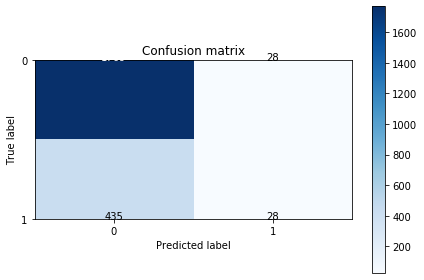

In [21]:
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,recall_score,classification_report 
lr = LogisticRegression(C = 1, penalty = 'l1')
lr.fit(X_train,y_train.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

## 加入代价敏感参数，重新计算

Recall metric in the testing dataset:  0.712742980561555


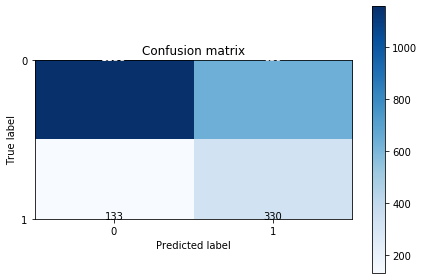

In [22]:
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,recall_score,classification_report 
lr = LogisticRegression(C = 1, penalty = 'l1', class_weight='balanced')
lr.fit(X_train,y_train.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

### 检验模型

<Figure size 432x288 with 0 Axes>

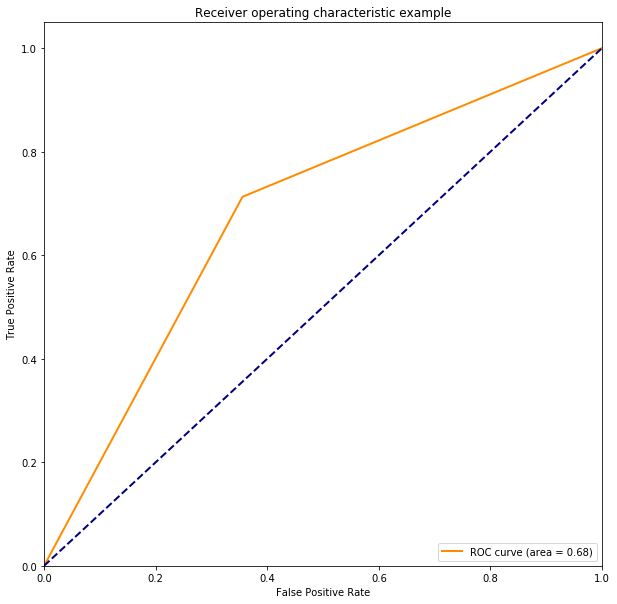

In [23]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,threshold = roc_curve(y_test,y_pred, drop_intermediate=False) ###计算真正率和假正率  
roc_auc = auc(fpr,tpr) ###计算auc的值  
  
plt.figure()  
lw = 2  
plt.figure(figsize=(10,10))  
plt.plot(fpr, tpr, color='darkorange',  
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线  
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Receiver operating characteristic example')  
plt.legend(loc="lower right")  
plt.show()

## 利用sklearn.metrics中的roc_curve算出tpr，fpr作图

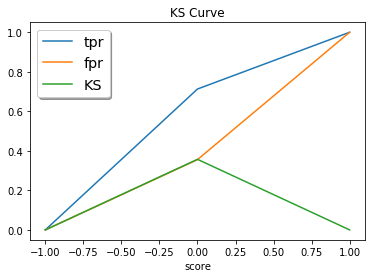

<Figure size 1440x1440 with 0 Axes>

In [24]:
fig, ax = plt.subplots()
ax.plot(1 - threshold, tpr, label='tpr') # ks曲线要按照预测概率降序排列，所以需要1-threshold镜像
ax.plot(1 - threshold, fpr, label='fpr')
ax.plot(1 - threshold, tpr-fpr,label='KS')
plt.xlabel('score')
plt.title('KS Curve')
#plt.xticks(np.arange(0,1,0.2), np.arange(1,0,-0.2))
#plt.xticks(np.arange(0,1,0.2), np.arange(score.max(),score.min(),-0.2*(data['反欺诈评分卡总分'].max() - data['反欺诈评分卡总分'].min())))
plt.figure(figsize=(20,20))
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

plt.show()